### 필요한 모듈을 가져오고 데이터를 로드합니다

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib
from mpl_finance import candlestick_ohlc
from datetime import datetime
import seaborn as sns
sns.set()

C:\ProgramData\Anaconda3\envs\tf-1\lib\site-packages\mpl_finance.py:22: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  category=DeprecationWarning)


In [2]:
# FinanceDataReader로 데이터를 불러옵니다
# 진단할 종목은 한양증권입니다. 기간은 2020.01.29~2021.02.01 입니다.

df = pd.read_csv('C:/Jupyter_Project/HanyangSecurities.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-29,8740,9120,8740,9120,9120,96112
1,2020-01-30,9350,9570,9200,9370,9370,175760
2,2020-01-31,9380,9710,9380,9570,9570,226732
3,2020-02-03,9440,9440,9030,9140,9140,99485
4,2020-02-04,9140,9150,9020,9110,9110,30886


In [3]:
date = [datetime.strptime(d, '%Y-%m-%d') for d in df['Date']]

In [4]:
candlesticks = list(zip(mdates.date2num(date),df['Open'],
                   df['High'],df['Low'],df['Close'],df['Volume']))

### 주가와 거래량 사이의 관계를 살펴봅니다

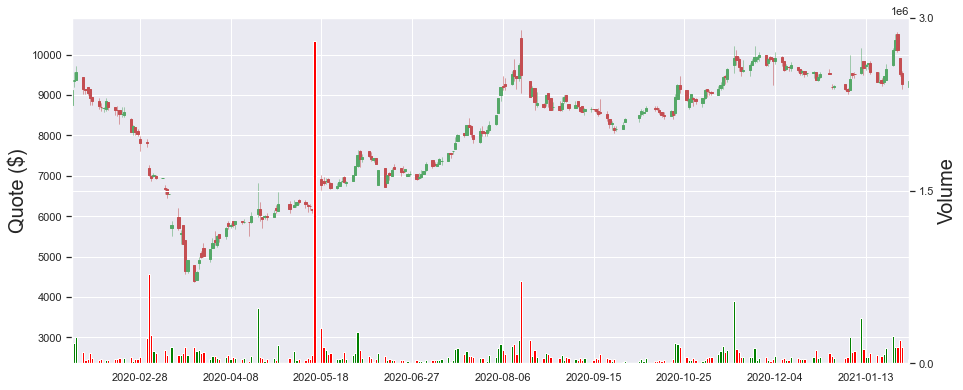

In [6]:
fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(1,1,1)
ax.set_ylabel('Quote ($)', size=20)

dates = [x[0] for x in candlesticks]
dates = np.asarray(dates)
volume = [x[5] for x in candlesticks]
volume = np.asarray(volume)

candlestick_ohlc(ax, candlesticks, width=1,
                 colorup='g', colordown='r')
pad = 0.25
yl = ax.get_ylim()
ax.set_ylim(yl[0]-(yl[1]-yl[0])*pad,yl[1])
ax2 = ax.twinx()

ax2.set_position(matplotlib.transforms.Bbox([[0.125,0],[0.9,0.32]]))

pos = df['Open'] - df['Close']<0
neg = df['Open'] - df['Close']>0
ax2.bar(dates[pos],volume[pos],color='green',width=1,align='center')
ax2.bar(dates[neg],volume[neg],color='red',width=1,align='center')

ax2.set_xlim(min(dates),max(dates))
yticks = ax2.get_yticks()
ax2.set_yticks(yticks[::3])

ax2.yaxis.set_label_position("right")
ax2.set_ylabel('Volume', size=20)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mticker.MaxNLocator(10))

plt.show()

In [7]:
def removal(signal, repeat):
    copy_signal = np.copy(signal)
    for j in range(repeat):
        for i in range(3, len(signal)):
            copy_signal[i - 1] = (copy_signal[i - 2] + copy_signal[i]) / 2
    return copy_signal

def get(original_signal, removed_signal):
    buffer = []
    for i in range(len(removed_signal)):
        buffer.append(original_signal[i] - removed_signal[i])
    return np.array(buffer)

signal = np.copy(df.Open.values)
removed_signal = removal(signal, 30)
noise_open = get(signal, removed_signal)

signal = np.copy(df.High.values)
removed_signal = removal(signal, 30)
noise_high = get(signal, removed_signal)

signal = np.copy(df.Low.values)
removed_signal = removal(signal, 30)
noise_low = get(signal, removed_signal)

signal = np.copy(df.Close.values)
removed_signal = removal(signal, 30)
noise_close = get(signal, removed_signal)

### 과매도 - 과매수 구간 시각화하기
> 그래프를 관찰하면 현재 한양증권의 주가는 Oversold line에 근접하고 있으며 이를 통해 유보하였다가 line을 돌파하면 구매하는 것이 바람직합니다

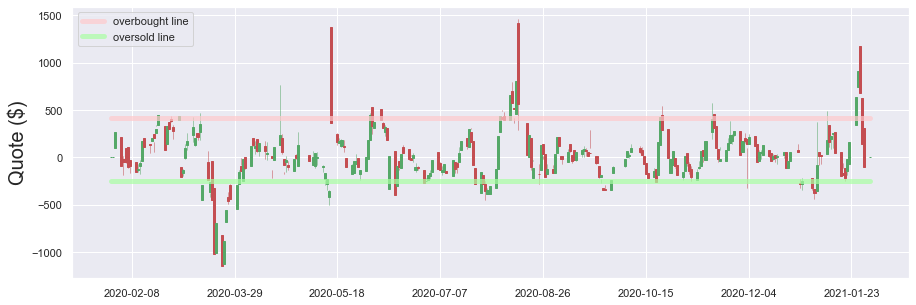

In [9]:
noise_candlesticks = list(zip(mdates.date2num(date),noise_open,
                              noise_high,noise_low,noise_close))

fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(1,1,1)
ax.set_ylabel('Quote ($)', size=20)

candlestick_ohlc(ax, noise_candlesticks, width=1,
                 colorup='g', colordown='r')

# ax.plot의 수치를 변화시켜서 overbought line을 관찰합니다
ax.plot(dates, [np.percentile(noise_close, 95)] * len(noise_candlesticks), color = (1.0, 0.792156862745098, 0.8, 0.7),
       linewidth=5.0, label = 'overbought line')

# ax.plot의 수치를 변화시켜서 oversold line을 관찰합니다
ax.plot(dates, [np.percentile(noise_close, 10)] * len(noise_candlesticks), 
        color = (0.6627450980392157, 1.0, 0.6392156862745098, 0.7),
       linewidth=5.0, label = 'oversold line')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mticker.MaxNLocator(10))

plt.legend()
plt.show()